In [1]:
import copy
import glob
import numpy as np
import os
import pandas as pd
import scipy
import scipy.stats
import tqdm
import warnings

In [2]:
import yt
import trident
import unyt

In [3]:
import kalepy as kale

In [4]:
import trove
import verdict

In [5]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use( '/Users/zhafen/repos/clean-bold/clean-bold.mplstyle' )
import palettable
import matplotlib.patheffects as path_effects

# Parameters

In [6]:
pm = {
    # Analysis 
    'prop_keys': [ 'vlos', 'T', 'nH', 'Z' ],
    'vel_prop_keys': [ 'vlos', 'T', 'nH', 'Z', 'NHI' ],
    'broaden_models': True,
    '1D_dist_estimation': 'kde',
    '1D_dist_estimation_data': 'histogram',
    '2D_dist_estimation': 'histogram',
    
    # Plotting Choices
    'smooth_2D_dist': 0.5,
    'upsample_2D_dist': 3,
    '2D_dist_data_display': 'histogram',
    'contour_levels': [ 90, 50 ],
    'contour_linewidths': [ 1, 3 ],
    'show_plots_in_nb': False,
}

In [7]:
# Load parameters
pm = trove.link_params_to_config(
    '/Users/zhafen/repos/cgm_modeling_challenge/sample2.trove',
    script_id = 'nb.2',
    variation = 'proposal',
    global_variation = '',
    **pm
)

In [8]:
redshift = pm['redshift']
prop_keys = pm['prop_keys']

In [9]:
data_dir = pm['data_dir']
base_data_dir = pm['base_data_dir']
ray_dir = os.path.join( base_data_dir, 'rays' )
results_dir = os.path.join( base_data_dir, 'modeling' )

## Analysis

In [10]:
correlation_coefficients = {
    'one-sided': {},
    'log one-sided': { 'logscale': True, 'subtract_mean': True },
    'two-sided': { 'one_sided': False, },
    'linear': { 'one_sided': False, 'subtract_mean': True },
    'log': { 'logscale': True, 'one_sided': False, 'subtract_mean': True },
}

In [11]:
lims = {
    'vlos': [ -300, 300 ],
    'T': [ 1e2, 2.5e6 ],
    'nH': [ 1e-7, 100 ],
    'Z': [ 1e-3, 30 ],
    'NHI': [ 1e9, 1e17 ],
}
autolims = {
    'vlos': False,
    'T': False,
    'nH': False,
    'Z': False,
    'NHI': False,
}

In [12]:
lims_1D = {
    'vlos': [ 3e9, 2e16 ],
    'T': [ 1e12, 1e20 ],
    'nH': [ 1e12, 1e20 ],
    'Z': [ 1e12, 1e20 ],
    'NHI': [ 1e12, 1e20 ],
}

In [13]:
dvs = {
    'vlos': 5.,
    'T': 0.05,
    'nH': 0.05,
    'Z': 0.05,
    'NHI': 0.05,
}

In [14]:
logscale = {
    'vlos': False,
    'T': True,
    'nH': True,
    'Z': True,
    'NHI': True,
}

In [15]:
bar_format = pm['bar_format']

## Plotting

In [16]:
labels = {
    'vlos': r'$v_{\rm LOS}$ [km/s]',
    'T': r'T [K]',
    'nH': r'$n_{\rm H}$ [cm$^{-3}$]',
    'Z': r'$Z$ [$Z_{\odot}$]',
    'NHI': r'$N_{\rm H\,I}$ [cm$^{-2}$]',
}
labels_1D = {
    'vlos': r'$\frac{ d N_{\rm H\,I} }{d v_{\rm LOS}}$',
    'T': r'$\frac{ d N_{\rm H\,I} }{d \log T}$',
    'nH': r'$\frac{ d N_{\rm H\,I} }{d \log n_{\rm H}}$',
    'Z': r'$\frac{ d N_{\rm H\,I} }{d \log Z}$',
    'NHI': r'$\frac{ d N_{\rm H\,I} }{d \log N_{\rm H\,I}}$',
}
r_labels = {}
for key, item in labels.items():
    unitless_label = item.split( '[' )[0]
    r_labels[key] = r'$r($ ' + unitless_label + r'$)$'
r_labels['all'] = r'$r($ all $)$'

In [17]:
correlation_markers = {
    'one-sided': '^',
    'log one-sided': '^',
    'two-sided': 'D',
    'linear': 'o',
    'log': 'o',
}
correlation_sizes = {
    'one-sided': 100,
    'log one-sided': 100,
    'two-sided': 80,
    'linear': 100,
    'log': 100,
}
correlations_plotted = [ 'linear', 'log' ]

In [18]:
mosaic = [
    [ 'vlos', 'legend', '.', '.' ],
    [ 'T_vlos', 'T', '.', '.' ],
    [ 'nH_vlos', 'nH_T', 'nH', '.' ],
    [ 'Z_vlos', 'Z_T', 'Z_nH', 'Z', ],
]
velocity_mosaic = [
    [ 'nH_vlos', 'vlos', ],
    [ 'Z_vlos', 'T_vlos', ],
]

In [19]:
panel_length = 4.

In [20]:
cmap = palettable.cartocolors.qualitative.Safe_10.mpl_colors
corr_cmap = palettable.cartocolors.diverging.Temps_2_r.mpl_colormap

In [21]:
corr_norm = matplotlib.colors.Normalize( vmin=0, vmax=1 )

In [22]:
def one_color_linear_cmap( color, name, f_white=0.95, f_saturated=1.0, ):
    '''A function that turns a single color into linear colormap that
    goes from a color that is whiter than the original color to a color
    that is more saturated than the original color.
    '''
    
    color_hsv = matplotlib.colors.rgb_to_hsv( color )
    start_color_hsv = copy.copy( color_hsv )
    
    start_color_hsv = copy.copy( color_hsv )
    start_color_hsv[1] -= f_white * start_color_hsv[1]
    start_color_hsv[2] += f_white * ( 1. - start_color_hsv[2] )
    start_color = matplotlib.colors.hsv_to_rgb( start_color_hsv )
    
    end_color_hsv = copy.copy( color_hsv )
    end_color_hsv[1] += f_saturated * ( 1. - end_color_hsv[1] )
    end_color = matplotlib.colors.hsv_to_rgb( end_color_hsv )
    
    return matplotlib.colors.LinearSegmentedColormap.from_list( name, [ start_color, end_color ] )

In [23]:
color_modeled = cmap[0]
color_data = cmap[1]
color_data = ( 0, 0, 0 )
cmap_modeled = one_color_linear_cmap( color_modeled, 'modeled' )
cmap_data = one_color_linear_cmap( color_data, 'data' )
cmap_data = matplotlib.colors.LinearSegmentedColormap.from_list( 'data', [ 'w', color_data ] )

In [24]:
contour_levels = pm['contour_levels']
contour_linewidths = pm['contour_linewidths']

# Tools

In [25]:
ldb = trident.LineDatabase(None)

read_sets: Using set file -- 
  /Users/zhafen/repos/linetools/linetools/lists/sets/llist_v1.3.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


In [26]:
def zeff_to_vel( zeff ):
    
    ainv2 = ( ( 1. + zeff ) / ( 1. + redshift ) )**2.
    
    v_div_c = ( ainv2 - 1. ) / ( ainv2 + 1. )
    return ( v_div_c * unyt.c ).to( 'km/s' )

# Load Data

## Modeled

In [27]:
# Get sightline filepaths
sl_fps = []
sls = []
other_files = []
for sl_fp in glob.glob( os.path.join( results_dir, '*' ) ):
    
    if not os.path.isdir( sl_fp ):
        other_files.append( sl_fp )
        continue
    
    i = os.path.split( sl_fp )[-1]
    
    if int( i ) in pm['selected_sightlines']:

        sl_fps.append( sl_fp )
        sls.append( i )

In [28]:
n_sample_turb = pm['n_sample_turb']

In [29]:
modeled_data_formats = {
    'v0': {
        'col_names': [ 'prob', 'likelihood', 'Z', 'nH', 'T', 'NHI', 'bturb', 'z', ],
        'col_units':  [ 1., 1., unyt.Zsun, unyt.cm**-3, unyt.K, unyt.cm**-2, unyt.km / unyt.s, 1. ],
        'vlos_from_z': True,
    },
    'v1': {
        'col_names': [ 'prob', 'likelihood', 'Z', 'nH', 'T', 'NHI', 'vlos', 'bturb', 'thickness' ],
        'col_units':  [ 1., -0.5, unyt.Zsun, unyt.cm**-3, unyt.K, unyt.cm**-2, unyt.km / unyt.s,  unyt.km / unyt.s, 1. ],
        'vlos_from_z': False,
    },
}

In [30]:
modeled_data_format = modeled_data_formats[pm['modeled_data_format']]
col_names = modeled_data_format['col_names']
col_units = modeled_data_format['col_units']

In [31]:
sl_datas = []
sl_useds = []
sl_compkeys = []
sl_stackeds = []
model_weightss = []
stacked_weightss = []
total_weightss = []
median_NHIs = []
for i, sl in enumerate( sls ):
    
    sl_fp = sl_fps[i]
    
    # Get text files

    sl_data = {}
    for component_fp in glob.glob( os.path.join( sl_fp, '*' ) ):
        component_key = os.path.splitext( os.path.split( component_fp )[-1] )[0]
        sl_data[component_key] = pd.read_csv( component_fp, sep=' ', names=col_names )
        
    # Add LOS velocity and reformat
    for component_key, df in sl_data.items():

        # Reformat
        new_entry = {}
        for name in col_names:
            values = unyt.unyt_array( df[name].values )
            if name in [ 'nH', 'T', 'Z', 'NHI', 'thickness' ]:
                new_entry[name] = 10.**values
            else:
                new_entry[name] = values

        # Add LOS velocity
        if modeled_data_format['vlos_from_z']:
            new_entry['vlos'] = zeff_to_vel( df['z'].values )

        # Setup units
        for j, name in enumerate( col_names ):
            new_entry[name] *= col_units[j]

        sl_data[component_key] = new_entry
    if modeled_data_format['vlos_from_z']:
        col_names.append( 'vlos' )
        
    # Turn samples into a list
    keys = sorted( list( sl_data.keys() ) )
    sl_formatted = {}
    for name in col_names:
        sl_formatted[name] = [ sl_data[_][name] for _ in keys ]

    # Generate modeled sample to plot ("generate" because we're sampling the doppler broadening)
    if pm['broaden_models']:
        sl_tiled = {}
        for name in col_names:
            sl_tiled[name] = []

        for j, vlos_j in enumerate( tqdm.tqdm( sl_formatted['vlos'], bar_format=bar_format ) ):
            sample_dist = scipy.stats.norm( loc=vlos_j, scale=sl_formatted['bturb'][j]/np.sqrt( 2. ) )
            sampled_values = sample_dist.rvs( ( n_sample_turb, vlos_j.size ) )

            for name in col_names:
                if name != 'vlos':
                    arr_tiled = np.hstack( np.tile( sl_formatted[name][j], ( n_sample_turb, 1 ),  ) )
                else:
                    arr_tiled = np.hstack( sampled_values )

                arr_tiled *= sl_formatted[name][j].units

                sl_tiled[name].append( arr_tiled )

        sl_used = sl_tiled
    else:
        sl_used = sl_formatted

    # Minimum weighting is to make sure no component is overweighted due to number of samples
    n_samples_max = np.max([ _.size for _ in sl_used['nH'] ])
    if pm['weighting'] is None:
        model_weights = [ np.full( _.size, n_samples_max / _.size ) for _ in sl_used['nH'] ]
    else:
        model_weights = [ np.full( _.size, np.nanmedian( _ ) * n_samples_max / _.size ) for _ in sl_used[pm['weighting']] ]
    model_weightss.append( model_weights )
    stacked_weightss.append( np.hstack( model_weights ) )
    total_weightss.append( np.array([ _.sum() for _ in model_weights ]) )
    median_NHIs.append( np.array([ np.nanmedian( _ ) for _ in sl_used['NHI'] ]) )

    sl_stacked = {}
    for key, item in sl_used.items():
        sl_stacked[key] = np.hstack( item ) * item[0].units
    
    sl_datas.append( sl_data )
    sl_useds.append( sl_used )
    sl_compkeys.append( keys )
    sl_stackeds.append( sl_stacked )

     100%|██████████| 7/7 [00:28<00:00,  4.04s/it]


### Best Estimates

In [32]:
raw_mle_data = pd.read_csv( other_files[0], sep=',', )

In [33]:
mle_data = verdict.Dict({})
for column_name in raw_mle_data.columns:
    
    # Get value
    value = raw_mle_data[column_name].values[0]
    comp_ion, comp_num, name = column_name.split( '_' )
    comp_key = '_'.join( [comp_ion, comp_num] )
    
    # Logscale
    if name in [ 'nH', 'T', 'Z', 'NHI', 'thickness' ]:
        value = 10.**value
    
    # Store data
    mle_data.setitem( name, value, comp_key, )
    
        
    if name == 'z':
        vlos_value = zeff_to_vel( value )
        mle_data.setitem( 'vlos', vlos_value, comp_key, )

In [34]:
# Setup units
for j, name in enumerate( col_names ):
    
    if ( name not in mle_data ) or ( name == 'vlos' ):
        continue
    
    mle_data[name] *= col_units[j]

## Actual

In [35]:
# Get rays
ray_fps = [ os.path.join( ray_dir, 'ray_{}.h5'.format( _[1:] ) ) for _ in sls ]
rays = [ yt.load( _ ) for _ in ray_fps ]

yt : [INFO     ] 2022-03-25 14:15:02,961 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-03-25 14:15:02,962 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2022-03-25 14:15:02,963 Parameters: domain_left_edge          = [0. 0. 0.] kpc
yt : [INFO     ] 2022-03-25 14:15:02,965 Parameters: domain_right_edge         = [95.7322 95.7322 95.7322] kpc
yt : [INFO     ] 2022-03-25 14:15:02,966 Parameters: cosmological_simulation   = 0.0


In [36]:
ray_datas = []
ray_weights = []
for ray in rays:
    # Ray properties
    trident.add_ion_fields(ray, ions=[ 'H I', ], line_database=ldb)
    den = ray.r[('gas', 'number_density')] * 0.75
    ray_data = {
        'nH': den,
        'NH': ( den * ray.r[('gas', 'dl')] ),
        'NHI': ray.r[('gas', 'H_p0_number_density')] * ray.r[('gas', 'dl')],
        'z': ray.r[('gas', 'redshift_eff')],
        'T': ray.r[('gas', 'temperature')],
        'Z': ray.r[('gas', 'metallicity')],
    }
    ray_data['vlos'] = zeff_to_vel( ray_data['z'] )
    
    if pm['sim_weighting'] is None:
        weights = np.ones( ray_data['NH'].shape )
    else:
        weights = copy.copy( ray_data[pm['sim_weighting']].value )
        weights[np.isclose(weights,0.)] = np.nan
    
    ray_datas.append( ray_data )
    ray_weights.append( weights )

yt : [INFO     ] 2022-03-25 14:15:03,000 Allocating for 1.024e+03 particles


## Bins and Limits

In [37]:
all_binss = []
all_dxs = []
all_centerss = []
for i, ray_data in enumerate( tqdm.tqdm( ray_datas, bar_format=bar_format ) ):
    
    sl_stacked = sl_stackeds[i]

    # Make bins, dx, and centers
    all_bins = {}
    all_dx = {}
    all_centers = {}
    for n_bins_key in [ 'n_bins_1D', 'n_bins_2D', 'n_bins_data_1D', 'n_bins_data_2D', 'n_bins_convolve' ]:
        n_bins = pm[n_bins_key]
        bins = {}
        for key, item in lims.items():
            if autolims[key]:
                low = np.nanmin(np.hstack([ sl_stacked[key], ray_data[key] ]))
                high = np.nanmax(np.hstack([ sl_stacked[key], ray_data[key] ]))
            else:
                low = item[0]
                high = item[1]
            if logscale[key]:
                bins[key] = np.logspace( np.log10( low ), np.log10( high ), n_bins )
            else:
                bins[key] = np.linspace( low, high, n_bins )

            bins[key] *= sl_stacked[key].units
        all_bins[n_bins_key] = bins

        dx = {}
        for key, bins_j in bins.items():
            if logscale[key]:
                dx[key] = np.log10( bins_j[1] ) - np.log10( bins_j[0] )
            else:
                dx[key] = float( ( bins_j[1] - bins_j[0] ).value )
        all_dx[n_bins_key] = dx

        centers = {}
        for key, bins_j in bins.items():

            if logscale[key]:
                bins_j = np.log10( bins_j )

            centers[key] = bins_j[:-1] + 0.5 * np.diff( bins_j )

            if logscale[key]:
                centers[key] = 10.**centers[key]
        all_centers[n_bins_key] = centers
        
    all_binss.append( all_bins )
    all_dxs.append( all_dx )
    all_centerss.append( all_centers )

     100%|██████████| 1/1 [00:00<00:00, 202.02it/s]


# Comparison Metrics

## Calculation

In [38]:
def calc_correlation( found, actual, logscale=False, one_sided=True, subtract_mean=False, ):
    '''Calculate the correlation coefficient.
    
    Args:
        found (array-like):
            Modeled data.
            
        actual (array-like):
            Actual data.
            
        logscale (bool):
            If True, do comparison after putting input arrays in logspace.
            
        one_sided (bool):
            If True, normalize by actual.sum()**2, not sqrt( found.sum()**2 * actual.sum()**2 ).
            
        subtract_mean (bool):
            If True, subtract the mean prior to calculating correlations.
    '''
    
    found = copy.copy( found )
    actual = copy.copy( actual )
    
    # Logscale
    if logscale:
        found = np.log10( found )
        actual = np.log10( actual )
    
    # Identify valid values
    found_valid = np.isfinite( found )
    actual_valid = np.isfinite( actual )
    is_valid = found_valid & actual_valid
    
    if subtract_mean:
        found -= np.mean( found[found_valid] )
        actual -= np.mean( actual[actual_valid] )
    
    # Calculate the correlation
    top = found * actual
    top_sum = top[is_valid].sum()
    
    # Calculate the normalization
    bottom = actual**2.
    bottom_sum = bottom[actual_valid].sum()
    if not one_sided:
        bottom_found = found**2.
        bottom_sum_found = bottom_found[found_valid].sum()
        bottom_sum = np.sqrt( bottom_sum * bottom_sum_found )
    
    return top_sum / bottom_sum

In [39]:
# Data structure for storing correlations
correlations_fp = os.path.join( pm['data_dir'], 'correlation.h5' )
correlations = verdict.Dict.from_hdf5( correlations_fp, create_nonexistent=True )

/Users/zhafen/repos/verdict/verdict.py:1410: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if hasattr( a[first_element_index][0], 'decode' ):


In [40]:
for i, sl in enumerate( tqdm.tqdm( sls, bar_format=bar_format ) ):

    # Setup correlation matrix
    for c_key in correlation_coefficients.keys():
        correlation_matrix = np.full( ( len( prop_keys ), len( prop_keys ) ), np.nan )
        correlations.setitem( c_key, correlation_matrix, 'matrix', sls[i] )

    # Get ray data
    ray_data = ray_datas[i]
    weights = ray_weights[i]

    # Get modeled data
    sl_stacked = sl_stackeds[i]
    model_weights = model_weightss[i]
    stacked_weights = stacked_weightss[i]

    # Get bins
    bins = all_binss[i]['n_bins_convolve']
    dx = all_dxs[i]['n_bins_convolve']
    centers = all_centerss[i]['n_bins_convolve']

    # Format for calculating distributions
    ray_data_histdd = []
    sl_stacked_histdd = []
    bins_histdd = []
    for key in prop_keys:

        arr_modeled = sl_stacked[key].value
        arr = ray_data[key].value
        bins_key = bins[key]

        if logscale[key]:
            arr_modeled = np.log10( arr_modeled )
            arr = np.log10( arr )
            bins_key = np.log10( bins_key )

        sl_stacked_histdd.append( arr_modeled )
        ray_data_histdd.append( arr )
        bins_histdd.append( bins_key )

    sl_stacked_histdd = np.array( sl_stacked_histdd ).transpose()
    ray_data_histdd = np.array( ray_data_histdd ).transpose()
    bins_histdd = np.array( bins_histdd )

    # Calculate ND distribution for ray data
    ray_dist_dd, bins_dd = np.histogramdd(
        ray_data_histdd,
        bins = bins_histdd,
        weights = weights,
    )
    ray_dist_dd /= ray_dist_dd.sum()

    # Calculate ND distribution for modeled data
    modeled_dist_dd, bins_dd = np.histogramdd(
        sl_stacked_histdd,
        bins = bins_histdd,
        weights = stacked_weights,
    )
    modeled_dist_dd /= modeled_dist_dd.sum()

    # Calculate net correlation coefficients
    for c_key, kwargs in correlation_coefficients.items():
        corr_ndim = calc_correlation( modeled_dist_dd, ray_dist_dd, **kwargs )
        correlations.setitem( c_key, corr_ndim, 'ndim', sls[i] )

    # Calculate correlation coefficients for each property
    for j, x_key in enumerate( prop_keys ):
        for k, y_key in enumerate( prop_keys ):

            # Avoid duplicates
            if k < j:
                continue

            ray_dist_2d, _, _ = np.histogram2d(
                ray_data_histdd[:,j],
                ray_data_histdd[:,k],
                bins = [ bins_histdd[j], bins_histdd[k] ],
                weights = weights,
            )
            ray_dist_2d /= ray_dist_2d.sum()

            modeled_dist_2d, _, _ = np.histogram2d(
                sl_stacked_histdd[:,j],
                sl_stacked_histdd[:,k],
                bins = [ bins_histdd[j], bins_histdd[k] ],
                weights = stacked_weights,
            )
            modeled_dist_2d /= modeled_dist_2d.sum()

            for c_key, kwargs in correlation_coefficients.items():

                correlation_matrix = correlations[c_key]['matrix'][sls[i]]
                correlation_matrix[j,k] = calc_correlation( modeled_dist_2d, ray_dist_2d, **kwargs )
                correlation_matrix[k,j] = correlation_matrix[j,k]
                correlations[c_key]['matrix'][sls[i]] = correlation_matrix


       0%|          | 0/1 [00:00<?, ?it/s]/var/folders/8x/jtlm_9mn1gd4ptwqw1yvxfrm0000gn/T/ipykernel_32132/499610613.py:26: RuntimeWarning: divide by zero encountered in log10
  found = np.log10( found )
/var/folders/8x/jtlm_9mn1gd4ptwqw1yvxfrm0000gn/T/ipykernel_32132/499610613.py:27: RuntimeWarning: divide by zero encountered in log10
  actual = np.log10( actual )
     100%|██████████| 1/1 [04:21<00:00, 261.29s/it]


In [41]:
correlations.to_hdf5( correlations_fp )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 133.00it/s]


## Corner Plot

     100%|██████████| 4/4 [00:00<00:00, 17.28it/s]


Saving figure to /Users/zhafen/repos/cgm_modeling_challenge/data/trove/sample2/proposal/figures/correlations_corner.png


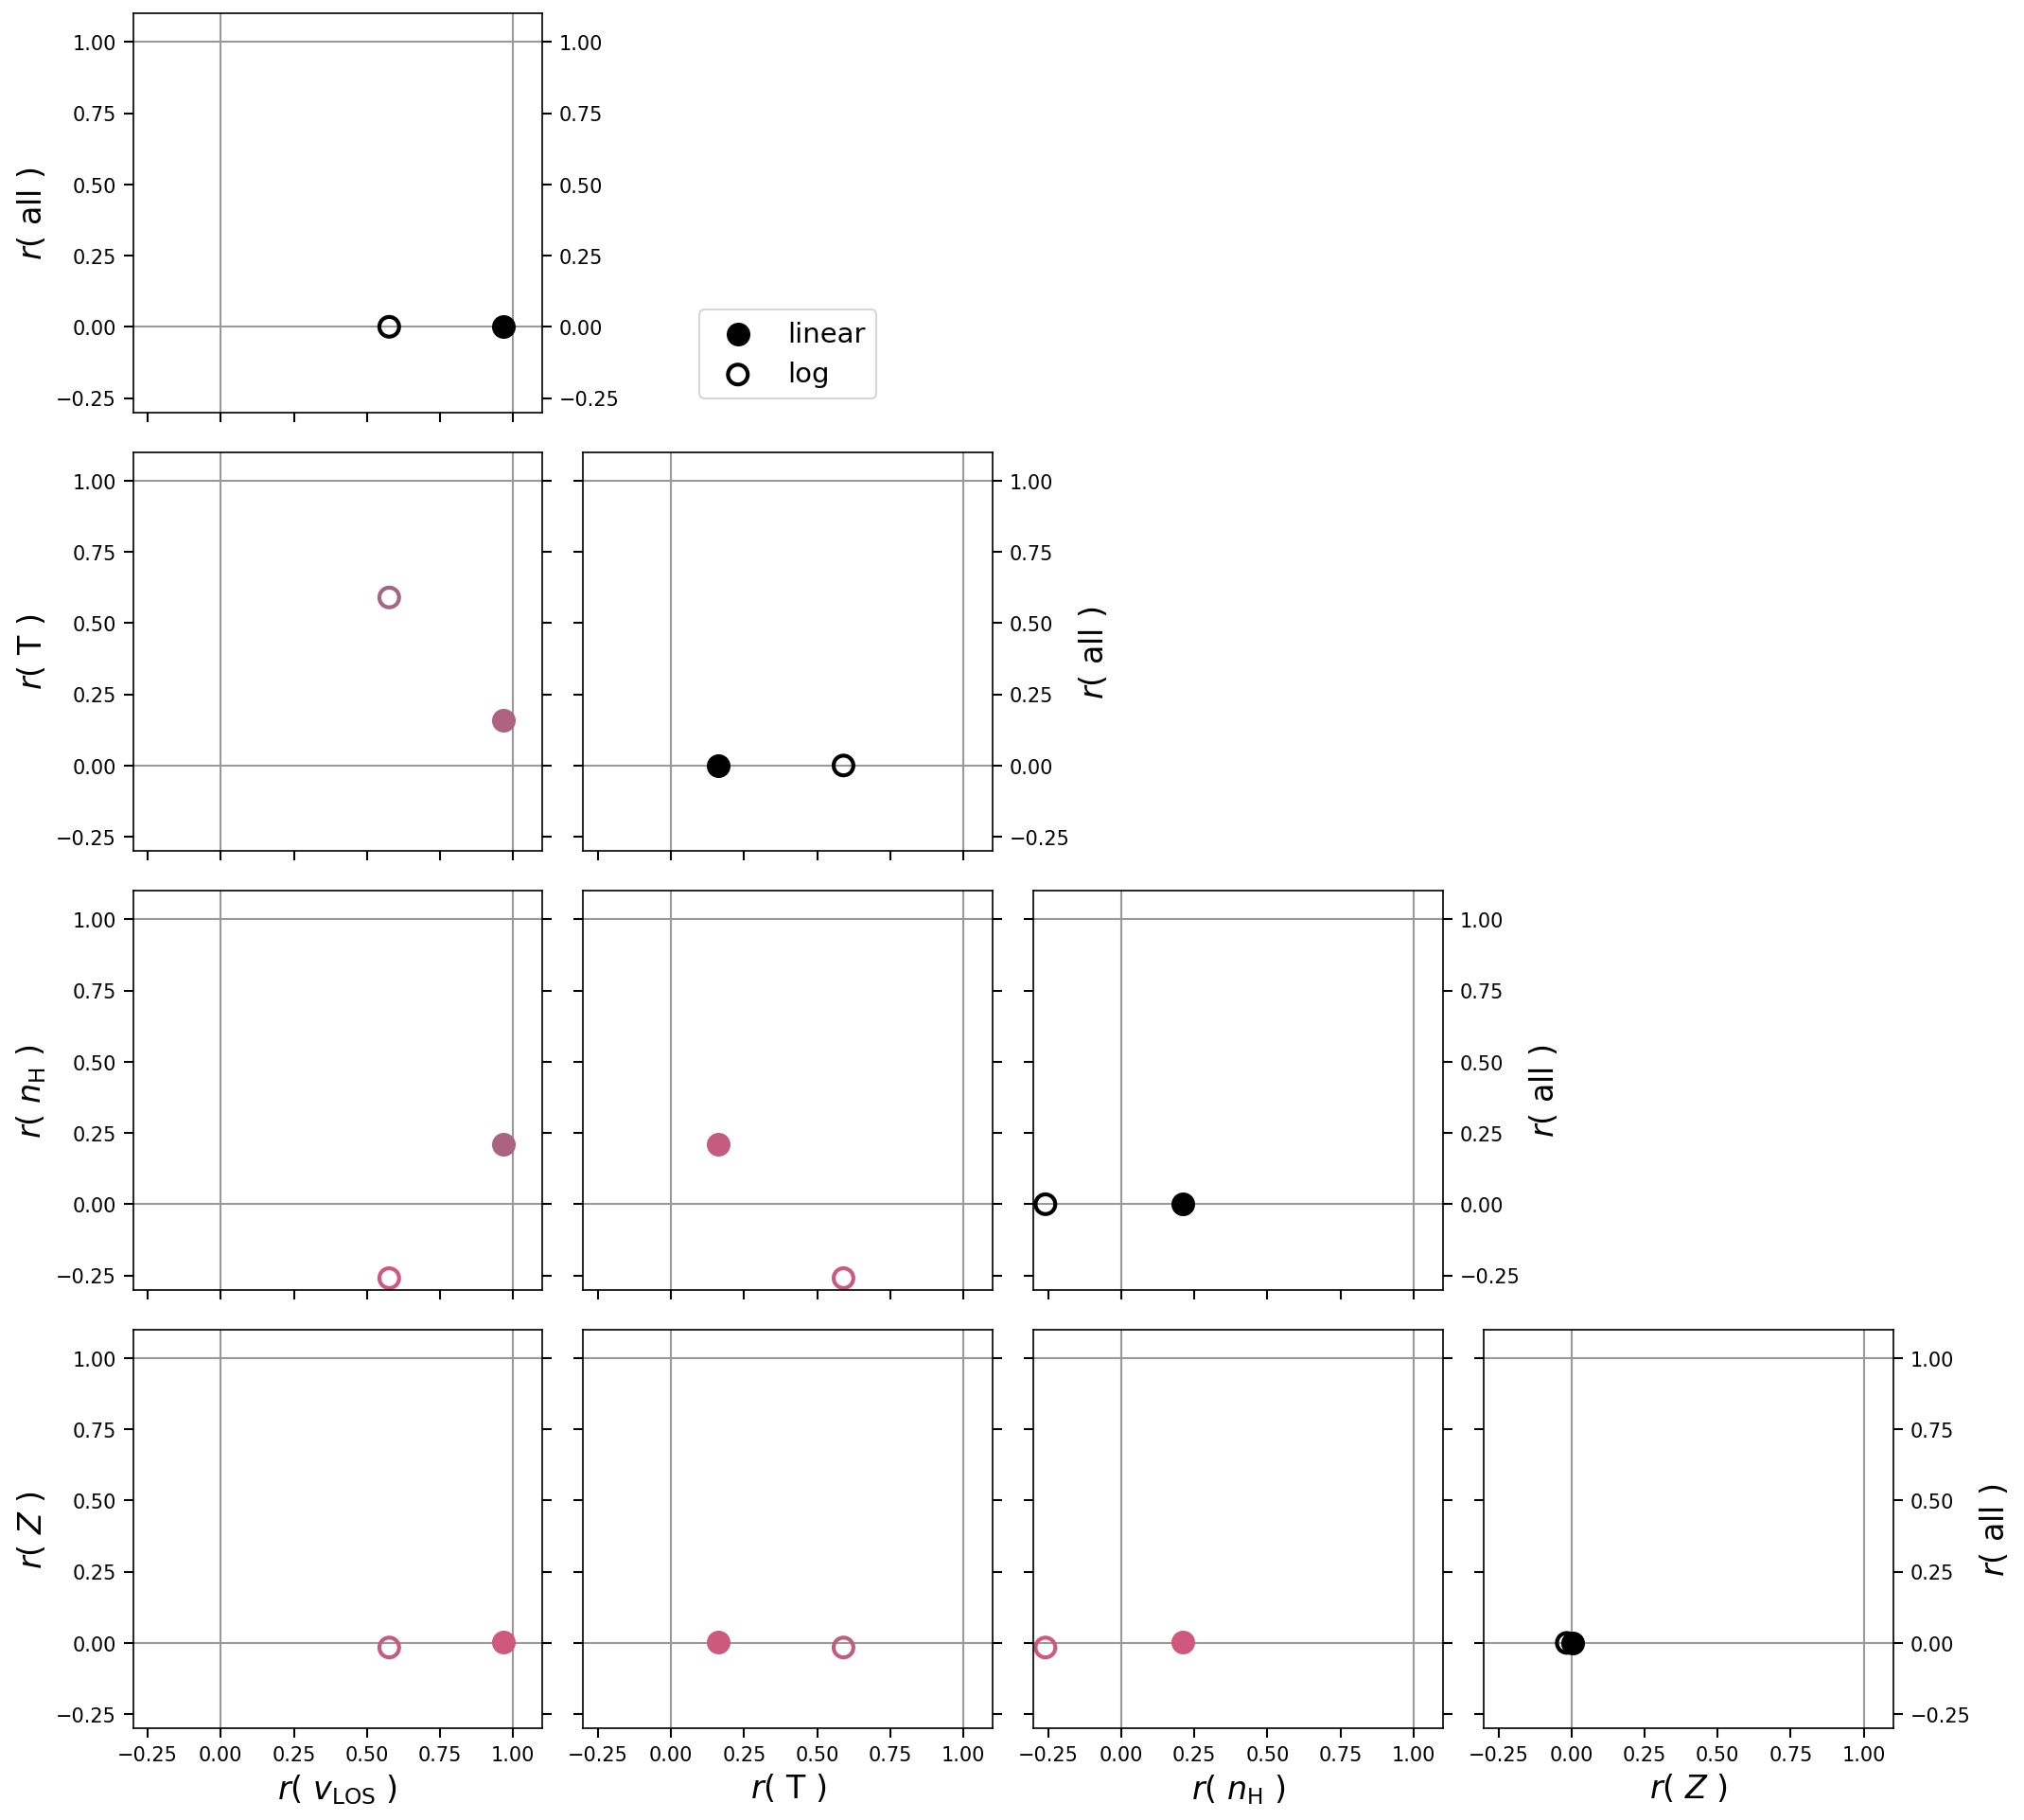

In [42]:
# Setup Figure
n_cols = len( prop_keys )
fig = plt.figure( figsize=( panel_length*n_cols, panel_length*n_cols ), facecolor='w' )
ax_dict = fig.subplot_mosaic(
    mosaic,
    gridspec_kw = { 'hspace': 0.1, 'wspace': 0.1 },
)

# Loop through all properties
for j, x_key in enumerate( tqdm.tqdm( prop_keys, bar_format=bar_format ) ):
    for k, y_key in enumerate( prop_keys ):

        # Avoid duplicates
        if k < j:
            continue
            
        # Comparison to ndim
        if j == k:
            ax = ax_dict[x_key]
            subplotspec = ax.get_subplotspec()

            x_label = r_labels[x_key]
            y_label = r_labels['all']
            
            for c_key in correlations_plotted:
                c_params = correlation_coefficients[c_key]
                facecolors = 'k'
                if 'logscale' in c_params:
                    if c_params['logscale']:
                        facecolors = 'none'
                
                scatter = ax.scatter(
                    correlations[c_key]['matrix'].array()[:,j,k],
                    correlations[c_key]['ndim'].array(),
                    label = c_key,
                    edgecolors = 'k',
                    facecolors = facecolors,
                    marker = correlation_markers[c_key],
                    s = correlation_sizes[c_key],
                    linewidth = 2,
                )
            
            if x_key in [ 'T', 'nH', 'Z' ]:
                ax.yaxis.set_label_position( 'right' )
                ax.set_ylabel( y_label, fontsize=16 )

            ax.tick_params(
                which = 'both',
                right = True,
                labelright = True,
            )
          
        # 2D comparisons
        else:
            try:
                ax = ax_dict['{}_{}'.format( x_key, y_key )]
            except KeyError:
                ax = ax_dict['{}_{}'.format( y_key, x_key )]
            subplotspec = ax.get_subplotspec()
            
            x_label = r_labels[x_key]
            y_label = r_labels[y_key]
            
            for c_key in correlations_plotted:
                colors = correlations[c_key]['matrix'].array()[:,j,k]
                colors = corr_cmap( corr_norm( colors ) )
                
                # Choose facecolor
                facecolors = colors
                c_params = correlation_coefficients[c_key]  
                if 'logscale' in c_params:
                    if c_params['logscale']:
                        facecolors = 'None'
                        
                ax.scatter(
                    correlations[c_key]['matrix'].array()[:,j,j],
                    correlations[c_key]['matrix'].array()[:,k,k],
                    edgecolors = colors,
                    facecolors = facecolors,
                    marker = correlation_markers[c_key],
                    s = correlation_sizes[c_key],
#                     norm = ,
                    linewidth = 2,
                )
        
        # Guiding lines
        for fn in [ ax.axvline, ax.axhline ]:
            for value in [ -1, 0, 1 ]:
                fn(
                    value,
                    color = pm['background_linecolor'],
                    linewidth = 1,
                    zorder = -100,
                )
        
        for fn in [ ax.set_xticks, ax.set_yticks ]:
            fn( np.arange( -1, 1.01, 0.25 ) )
        ax.tick_params(
            which = 'both',
            right = True,
            labelleft = subplotspec.is_first_col(),
            labelbottom = subplotspec.is_last_row(),
        )
        
        ax.set_xlim( -0.3, 1.1 )
        ax.set_ylim( -0.3, 1.1 )

        if subplotspec.is_last_row():
            ax.set_xlabel( x_label, fontsize=16 )
        if subplotspec.is_first_col():
            ax.set_ylabel( y_label, fontsize=16 )
            
# Add a legend
h, l = ax_dict['vlos'].get_legend_handles_labels()
ax_dict['legend'].legend( h, l, loc='lower center', prop={'size': 14}, )
ax_dict['legend'].axis( 'off' )

# Save
savedir = os.path.join( pm['data_dir'], 'figures' )
os.makedirs( savedir, exist_ok=True )
savefile = 'correlations_corner.png'
save_fp = os.path.join( savedir, savefile )
print( 'Saving figure to {}'.format( save_fp ) )
plt.savefig( save_fp, bbox_inches='tight' )

## Clean Comparison

In [43]:
n_sls = len( sls )
xs = np.linspace( -0.5, 0.5, n_sls ) / 2

In [44]:
clean_mosaic = [
    [ 'all', 'all', 'all', 'legend' ],
    [ 'vlos', 'vlos', 'T', 'T', ],
    [ 'nH', 'nH', 'Z', 'Z', ],
]

     100%|██████████| 4/4 [00:00<00:00, 447.18it/s]


Saving figure to /Users/zhafen/repos/cgm_modeling_challenge/data/trove/sample2/proposal/figures/correlations.png


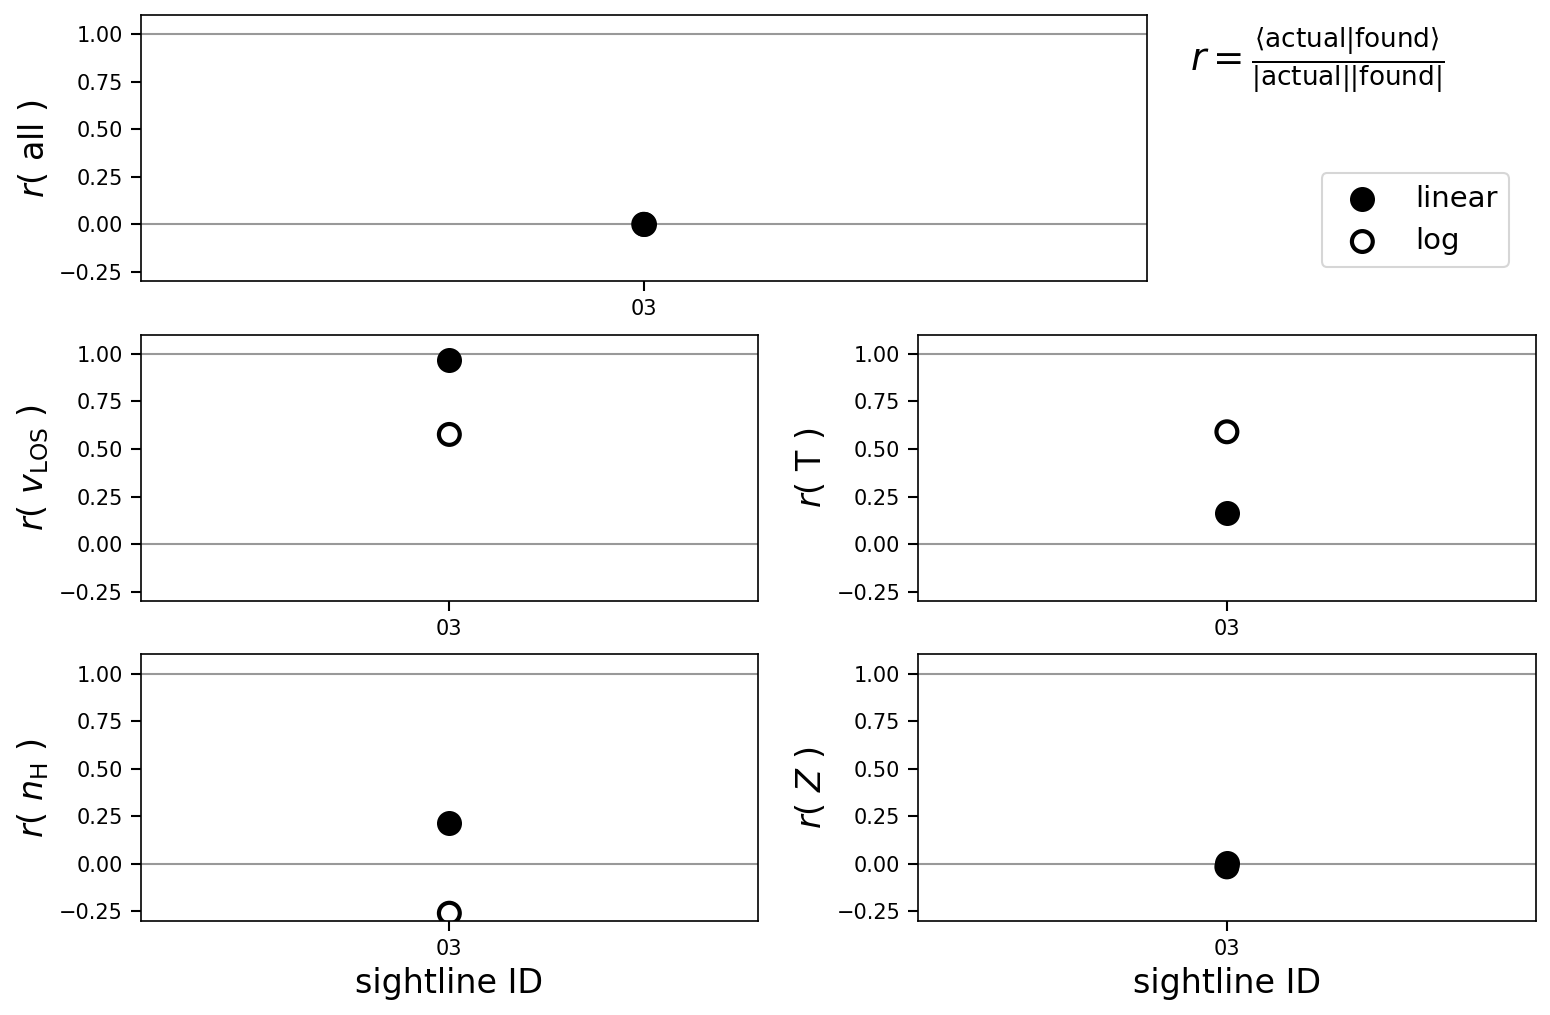

In [45]:
# Setup Figure
n_rows_clean = len( clean_mosaic )
n_cols_clean = 2
fig = plt.figure( figsize=(n_rows_clean*panel_length, n_cols_clean*panel_length), facecolor='w' )
ax_dict = fig.subplot_mosaic(
    clean_mosaic,
    gridspec_kw = { 'wspace': 0.7 },
)

def r_scatter( ax, ys, c_key ):
    c_params = correlation_coefficients[c_key]
    facecolors = 'k'
    if 'logscale' in c_params:
        if c_params['logscale']:
            facecolors = 'none'

    scatter = ax.scatter(
        xs,
        ys,
        label = c_key,
        edgecolors = 'k',
        facecolors = facecolors,
        marker = correlation_markers[c_key],
        s = correlation_sizes[c_key],
        linewidth = 2,
    )
    
# Overall
for c_key in correlations_plotted:
    r_scatter(
        ax_dict['all'],
        correlations[c_key]['ndim'].array(),
        c_key
    )

# Each property
for j, x_key in enumerate( tqdm.tqdm( prop_keys, bar_format=bar_format ) ):
    
    ax = ax_dict[x_key]
    
    for c_key in correlations_plotted:
        r_scatter(
            ax,
            correlations[c_key]['matrix'].array()[:,j,j],
            c_key
        )
    
        
# Add a legend
h, l = ax_dict['vlos'].get_legend_handles_labels()
ax_dict['legend'].legend( h, l, loc='lower left', prop={'size': 14}, )
ax_dict['legend'].axis( 'off' )
ax_dict['legend'].annotate(
    text = r'$r = \frac{ \langle {\rm actual } \vert  {\rm found } \rangle }{ \vert {\rm actual} \vert \vert {\rm found } \vert }$',
    xy = ( 0, 1 ),
    xycoords = 'axes fraction',
    xytext = ( 5, -5 ),
    textcoords = 'offset points',
    ha = 'center',
    va = 'top',
    fontsize = 18,
)
        
# Cleanup
for x_key, ax in ax_dict.items():
    
    if x_key == 'legend':
        continue
    
    subplotspec = ax.get_subplotspec()
    
    for value in [ -1, 0, 1 ]:
        ax.axhline(
            value,
            color = pm['background_linecolor'],
            linewidth = 1,
            zorder = -100,
        )
        
    ax.set_ylabel( r_labels[x_key], fontsize=16 )
    if subplotspec.is_last_row():
        ax.set_xlabel( 'sightline ID', fontsize=16 )
        
    ax.set_xticks( xs )
    xtick_labels = [ _[-2:] for _ in correlations[c_key]['ndim'].keys_array() ]
    ax.set_xticklabels( xtick_labels )
        
    ax.set_ylim( -0.3, 1.1 )
    
# Save
savedir = os.path.join( pm['data_dir'], 'figures' )
os.makedirs( savedir, exist_ok=True )
savefile = 'correlations.png'
save_fp = os.path.join( savedir, savefile )
print( 'Saving figure to {}'.format( save_fp ) )
plt.savefig( save_fp, bbox_inches='tight' )

# Ray-by-Ray Comparison

## Setup

### Other Setup

In [46]:
class ContourCalc( object ):
    
    def __init__( self, arr ):
        
        is_not_nan = np.invert( np.isnan( arr ) )
        is_finite = np.invert( np.isinf( arr ) )
        is_valid = is_not_nan & is_finite
        self.values_sorted = np.sort( arr[is_valid] )[::-1]
        
        self.values_fraction = np.cumsum( self.values_sorted )
        self.values_fraction /= self.values_fraction[-1]
        
        self.interp_fn = scipy.interpolate.interp1d( self.values_fraction, self.values_sorted )
        
    def get_level( self, q, f_min_is_average=True ):
        
        f = np.array( q ) / 100.
        
        if f_min_is_average:
            f_min = 0.5 * ( self.values_fraction[0] + self.values_fraction[1] )
        else:
            f_min = self.values_fraction[0]
        
        if pd.api.types.is_list_like( f ):
            f = np.array( f )
            f[f<f_min] = f_min
        else:
            if f < f_min:
                f = f_min

        return self.interp_fn( f ) 

## Corner Plot

In [47]:
for i, ray in enumerate( rays ):
    
    print( '\nMaking comparison for ray {}\n'.format( i ) )

    ray_data = ray_datas[i]
    weights = ray_weights[i]

    # Modeled sightline
    sl_data = sl_datas[i]
    sl_used = sl_useds[i]
    sl_stacked = sl_stackeds[i]
    model_weights = model_weightss[i]
    stacked_weights = stacked_weightss[i]
    total_weights = total_weightss[i]
    median_NHI = median_NHIs[i]
    
    all_bins = all_binss[i]
    all_dx = all_dxs[i]
    all_centers = all_centerss[i]
    
    bins = all_bins['n_bins_1D']
    dx = all_dx['n_bins_1D']
    centers = all_centers['n_bins_1D']
    
    # Setup Figurea
    n_cols = len( prop_keys )
    fig = plt.figure( figsize=( panel_length*n_cols, panel_length*n_cols ), facecolor='w' )
    ax_dict = fig.subplot_mosaic( mosaic )

    # Loop through all properties
    for j, x_key in enumerate( tqdm.tqdm( prop_keys, bar_format=bar_format ) ):
        for k, y_key in enumerate( prop_keys ):

            # Avoid duplicates
            if k < j:
                continue
            
#             # DEBUG
#             if j != 1 and k != 0:
#                 continue

            # Check for out-of-bounds
            oob_labels = [ 'modeled', 'ray' ]
            for ii, key in enumerate([ x_key, y_key ]):
                for jj, values in enumerate([ sl_stacked[key], ray_data[key] ]):
                    n_low = ( values < bins[key][0] ).sum()
                    n_high = ( values > bins[key][-1] ).sum()
                    bounds = [ 'below', 'above' ]
                    for kk, n_oob in enumerate([ n_low, n_high ]):
                        if n_oob / values.size > 0.02:
                            warnings.warn(
                                '{} {} points ({:.2g}%) with {} {} {:.3g}'.format(
                                    n_oob,
                                    oob_labels[jj],
                                    n_oob / values.size * 100,
                                    key,
                                    bounds[kk],
                                    lims[key][kk],
                                )
                            )

            # 1D histogram
            if j == k:
                ax = ax_dict[x_key]
                subplotspec = ax.get_subplotspec()

                x_label = labels[x_key]
                y_label = labels_1D[x_key]
                
                bins = all_bins['n_bins_1D']
                dx = all_dx['n_bins_1D']
                centers = all_centers['n_bins_1D']

                # Observational
                if pm['1D_dist_estimation'] == 'histogram':
                    hist_o, edges = np.histogram(
                        sl_stacked[x_key],
                        bins = bins[x_key],
                        weights = stacked_weights,
                        density = False,
                    )
                    hist_o /= hist_o.sum() * dx[x_key]
                    ax.step(
                        edges[:-1],
                        hist_o,
                        color = color_modeled,
                        where = 'post',
                        linewidth = 2,
                    )
                elif pm['1D_dist_estimation'] == 'kde':
                    # Change to logspace for kde
                    if logscale[x_key]:
                        sl_kde = np.log10( sl_stacked[x_key] )
                        kde_centers = np.log10( centers[x_key] )
                    else:
                        sl_kde = sl_stacked[x_key].value
                        kde_centers = centers[x_key].value
                    kde_centers, hist_o = kale.density(
                            sl_kde,
                            points = kde_centers,
                            weights = stacked_weights,
                            probability = False,
                        )
                    hist_o /= hist_o.sum() * dx[x_key]
                    hist_o *= median_NHI.sum()
                    ax.plot(
                        centers[x_key],
                        hist_o,
                        linewidth = 5,
                        color = 'k',
                        label = 'modeled',
                    )
                    
                    # Individual components
                    for kk, sl_used_x in enumerate( sl_used[x_key] ):       
                        if logscale[x_key]:
                            sl_used_x = np.log10( sl_used_x )
                        else:
                            sl_used_x = sl_used_x.value
                        kde_centers, hist_o = kale.density(
                                sl_used_x,
                                points = kde_centers,
                                weights = model_weights[kk],
                                probability = False,
                            )
                        hist_o /= hist_o.sum() * dx[x_key]
                        hist_o *= median_NHI[kk]
                        
                        # Cycle through colors, skipping the color reserved for the ray data
                        if kk == 0:
                            cmap_kk = kk
                        else:
                            cmap_kk = kk + 1
                    
                        ax.plot(
                            centers[x_key],
                            hist_o,
                            linewidth = 2,
                            color = cmap[cmap_kk],
                            label = r'    component $\log N_{\rm H\,I}=$' + '{:.3g}'.format( np.log10( median_NHI[kk] ) ),
                        )

                # Ray
                bins = all_bins['n_bins_data_1D']
                dx = all_dx['n_bins_data_1D']
                centers = all_centers['n_bins_data_1D']
                
                if pm['1D_dist_estimation_data'] == 'histogram':
                    hist_r, edges = np.histogram(
                        ray_data[x_key],
                        bins = bins[x_key],
                        weights = weights,
                        density = False,
                    )
                    hist_r /= hist_r.sum() * dx[x_key]
                    hist_r *= ray_data['NHI'].sum()
                    ax.fill_between(
                        edges[:-1],
                        hist_r,
                        color = color_data,
                        step = 'post',
                        label = 'data',
                    )
                elif pm['1D_dist_estimation_data'] == 'kde':
                    # Change to logspace for kde
                    if logscale[x_key]:
                        sl_kde = np.log10( ray_data[x_key] )
                        kde_centers = np.log10( centers[x_key] )
                    else:
                        sl_kde = ray_data[x_key].value
                        kde_centers = centers[x_key].value
                    kde_centers, hist_r = kale.density(
                            sl_kde,
                            points = kde_centers,
                            weights = weights,
                            probability = False,
                        )
                    hist_r /= hist_r.sum() * dx[x_key]
                    hist_r *= ray_data['NHI'].sum()
                    ax.fill_between(
                        centers[x_key],
                        hist_r,
                        color = color_data,
                    )

#                 y_min = 10.**np.nanmin( [ np.nanmin( np.log10( hist_o[hist_o>0] ) ), np.nanmin( np.log10( hist_r[hist_r>0] ) ) ] )
#                 y_min = lims_1D[x_key]
#                 y_max = np.nanmax([ np.nanmax( hist_r ), np.nanmax( hist_o ) ])
#                 ax.set_ylim( y_min, y_max * 1.05 )
                ax.set_ylim( lims_1D[x_key] )
                ax.set_xlim( bins[x_key][0], bins[x_key][-1] )

                if logscale[x_key]:
                    ax.set_xscale( 'log' )
                ax.set_yscale( 'log' )
                
                if x_key in [ 'T', 'nH', 'Z' ]:
                    ax.yaxis.set_label_position( 'right' )
                    ax.set_ylabel( y_label, fontsize=16 )

                ax.tick_params(
                    which = 'both',
                    right = True,
                    labelright = True,
                )

            # 2D histogram
            else:
                
                bins = all_bins['n_bins_2D']
                dx = all_dx['n_bins_2D']
                centers = all_centers['n_bins_2D']
                
                centers_x = copy.copy( centers[x_key] )
                centers_y = copy.copy( centers[y_key] )
                
                try:
                    ax = ax_dict['{}_{}'.format( x_key, y_key )]
                except KeyError:
                    ax = ax_dict['{}_{}'.format( y_key, x_key )]
                subplotspec = ax.get_subplotspec()
                              
                # Upsample centers
                upsample = pm['upsample_2D_dist']
                if upsample is not None:
                    centers_x = scipy.ndimage.zoom( centers_x, upsample )
                    centers_y = scipy.ndimage.zoom( centers_y, upsample )
                
                # Observational per component
                img_arr_comps = []
                    
                for kk, sl_used_x in enumerate( sl_used[x_key] ):
                    sl_used_y = sl_used[y_key][kk]
                    norm_kk = total_weights[kk] * dx[x_key] * dx[y_key]
                    
                    # Histogram version
                    if pm['2D_dist_estimation'] == 'histogram':
                        hist2d_kk, x_edges, y_edges = np.histogram2d(
                            sl_used_x,
                            sl_used_y,
                            bins = [ bins[x_key], bins[y_key], ],
                            weights = model_weights[kk] / norm_kk,
                        )
                        img_arr_kk = np.transpose( hist2d_kk )
                        
                    # KDE version
                    elif pm['2D_dist_estimation'] == 'kde':
                        
                        # Change to logspace for kde
                        if logscale[x_key]:
                            sl_used_x = np.log10( sl_used_x )
                            kde_centers_x = np.log10( centers_x )
                        else:
                            kde_centers_x = centers[x_key]
                        if logscale[y_key]:
                            sl_used_y = np.log10( sl_used_y )
                            kde_centers_y = np.log10( centers_y )
                        else:
                            kde_centers_y = centers[y_key]
                            
                        kde_data = np.array([ sl_used_x, sl_used_y ])
                        points, img_arr_kk = kale.density(
                            kde_data,
                            points = [ kde_centers_x, kde_centers_y ],
                            grid = True,
                            weights = model_weights[kk] / norm_kk,
                        )
                        
                    # Upsample and smooth
                    if upsample is not None:
                        img_arr_kk = scipy.ndimage.zoom( img_arr_kk, upsample )                                                                                                
                    
                    if pm['smooth_2D_dist'] is not None:
                        if upsample is not None:                                                   
                            sigma = upsample * pm['smooth_2D_dist']
                        else:
                            sigma = pm['smooth_2D_dist']
                        img_arr_kk = scipy.ndimage.filters.gaussian_filter( img_arr_kk, sigma )
        
                    # Get levels corresponding to percentages enclose
                    c_calc_kk = ContourCalc( img_arr_kk )
                    levels = c_calc_kk.get_level( contour_levels )
                
                    # Cycle through colors, skipping the color reserved for the ray data
                    if kk == 0:
                        cmap_kk = kk
                    else:
                        cmap_kk = kk + 1
                    contour_colors = [ cmap[cmap_kk], ] * len( levels )
                        
                    # Prevent invisible low-contribution components
                    alpha_min = 0.5
                    contour_alpha = ( total_weights[kk] / total_weights.max() ) * ( 1. - alpha_min ) + alpha_min
                    
                    ax.contour(
                        centers_x,
                        centers_y,
                        img_arr_kk,
                        levels,
                        colors = contour_colors,
                        linewidths = contour_linewidths,
                        alpha = contour_alpha
                    )
                    
                # Ray
                bins = all_bins['n_bins_data_2D']
                dx = all_dx['n_bins_data_2D']
                centers = all_centers['n_bins_data_2D']
                
                used_weights = weights / ( weights.sum() * dx[x_key] * dx[y_key] )
                hist2d_r, x_edges, y_edges = np.histogram2d(
                    ray_data[x_key],
                    ray_data[y_key],
                    bins = [ bins[x_key], bins[y_key], ],
                    weights = used_weights,
                )
                img_arr_r = np.transpose( hist2d_r )
                
                if pm['2D_dist_data_display'] == 'histogram':
                    ax.pcolormesh(
                        centers[x_key],
                        centers[y_key],
                        img_arr_r,
                        cmap = cmap_data,
                        shading = 'nearest',
                        norm = matplotlib.colors.LogNorm(),
                    )
                elif pm['2D_dist_data_display'] == 'contour':
                    
                    contour_centers_x = copy.copy( all_centers['n_bins_data_2D'][x_key] )
                    contour_centers_y = copy.copy( all_centers['n_bins_data_2D'][y_key] )

                    # Upsample and smooth
                    if upsample is not None:
                        img_arr_r = scipy.ndimage.zoom( img_arr_r, upsample )
                        
                        contour_centers_x = scipy.ndimage.zoom( contour_centers_x, upsample )
                        contour_centers_y = scipy.ndimage.zoom( contour_centers_y, upsample )

                    if pm['smooth_2D_dist'] is not None:
                        if upsample is not None:                                                   
                            sigma = upsample * pm['smooth_2D_dist']
                        else:
                            sigma = pm['smooth_2D_dist']
                        img_arr_r = scipy.ndimage.filters.gaussian_filter( img_arr_r, sigma )

                    # Get levels corresponding to percentages enclose
                    c_calc_kk = ContourCalc( img_arr_r )
                    levels = c_calc_kk.get_level( contour_levels + [ -1, ], False )
                    
                    ax.contourf(
                        contour_centers_x,
                        contour_centers_y,
                        img_arr_r,
                        levels,
                        cmap = cmap_data,
                        zorder = -100,
                    )

                ax.set_xlim( bins[x_key][0], bins[x_key][-1] )
                ax.set_ylim( bins[y_key][0], bins[y_key][-1] )

                if logscale[x_key]:
                    ax.set_xscale( 'log' )
                if logscale[y_key]:
                    ax.set_yscale( 'log' )

                x_label = labels[x_key]
                y_label = labels[y_key]

            if subplotspec.is_last_row():
                ax.set_xlabel( x_label, fontsize=16 )
            if subplotspec.is_first_col():
                ax.set_ylabel( y_label, fontsize=16 )
                
            # Correlation coefficient annotation
            coeff = correlations['log']['matrix'][sls[i]][j,k]
            text = r'$r =$' + '{:.2f}'.format( coeff ) 
            annot = ax.annotate(
                text = text,
                xy = ( 1, 1 ),
                xycoords = 'axes fraction',
                xytext = ( -5, -5 ),
                textcoords = 'offset points',
                va = 'top',
                ha = 'right',
                fontsize = 14,
                color = 'w',
            )
            coeff_color = corr_cmap( corr_norm( coeff ) )
            annot.set_path_effects([
                path_effects.Stroke( linewidth=3, foreground=coeff_color ),
                path_effects.Normal()
            ])
                
    # Add a legend
    h, l = ax_dict['vlos'].get_legend_handles_labels()
    ax_dict['legend'].legend( h, l, loc='lower left', prop={'size': 12}, )
    ax_dict['legend'].axis( 'off' )
    
    # Ray number
    annot = ax_dict['legend'].annotate(
        text = 'sightline {}'.format( sls[i][-2:] ),
        xy = ( 0.5, 1 ),
        xycoords = 'axes fraction',
        xytext = ( 5, -5 ),
        textcoords = 'offset points',
        va = 'top',
        ha = 'center',
        fontsize = 16,
        color = 'k',
    )

    # Save
    savedir = os.path.join( pm['data_dir'], 'figures' )
    os.makedirs( savedir, exist_ok=True )
    savefile = 'sightline_{}.png'.format( os.path.basename( sl_fps[i] ) )
    save_fp = os.path.join( savedir, savefile )
    print( 'Saving figure to {}'.format( save_fp ) )
    plt.savefig( save_fp, bbox_inches='tight' )
    
    if not pm['show_plots_in_nb']:
        plt.close()


Making comparison for ray 0



       0%|          | 0/4 [00:00<?, ?it/s]/var/folders/8x/jtlm_9mn1gd4ptwqw1yvxfrm0000gn/T/ipykernel_32132/1630535904.py:278: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  img_arr_kk = scipy.ndimage.filters.gaussian_filter( img_arr_kk, sigma )
      25%|██▌       | 1/4 [09:10<27:32, 550.73s/it]/var/folders/8x/jtlm_9mn1gd4ptwqw1yvxfrm0000gn/T/ipykernel_32132/1630535904.py:278: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  img_arr_kk = scipy.ndimage.filters.gaussian_filter( img_arr_kk, sigma )
      50%|█████     | 2/4 [17:18<17:07, 513.92s/it]/var/folders/8x/jtlm_9mn1gd4ptwqw1yvxfrm0000gn/T/ipykernel_32132/1630535904.py:278: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  img_arr_kk = scipy.ndimage.filters.gauss

Saving figure to /Users/zhafen/repos/cgm_modeling_challenge/data/trove/sample2/proposal/figures/sightline_0003.png


## Properties at a Given $v_{LOS}$

In [48]:
contour_levels = [ 50, ]
contour_linewidth = [ 2, ]

In [49]:
vel_prop_keys = pm['vel_prop_keys']

In [50]:
ray_hists_1d = {}
ray_hists_2d = {}
for i, ray in enumerate( rays ):
    
    print( '\nMaking comparison for ray {}\n'.format( i ) )

    ray_data = ray_datas[i]
    weights = ray_weights[i]

    # Modeled sightline
    sl_data = sl_datas[i]
    sl_used = sl_useds[i]
    compkeys = sl_compkeys[i]
    sl_stacked = sl_stackeds[i]
    model_weights = model_weightss[i]
    stacked_weights = stacked_weightss[i]
    total_weights = total_weightss[i]
    median_NHI = median_NHIs[i]
    
    all_bins = all_binss[i]
    all_dx = all_dxs[i]
    all_centers = all_centerss[i]
    
    bins = all_bins['n_bins_1D']
    dx = all_dx['n_bins_1D']
    centers = all_centers['n_bins_1D']
    
    # Setup Figurea
    n_cols = len( vel_prop_keys )
    fig = plt.figure( figsize=( panel_length*n_cols/2., panel_length*n_cols/2. ), facecolor='w' )
    ax_dict = fig.subplot_mosaic(
        velocity_mosaic,
        gridspec_kw = { 'wspace': 0.32 },
    )

    # Loop through all properties
    for j, x_key in enumerate( tqdm.tqdm( vel_prop_keys, bar_format=bar_format ) ):
        for k, y_key in enumerate( vel_prop_keys ):

            # Avoid duplicates
            if k < j:
                continue
            
#             # DEBUG
#             if j != 1 and k != 0:
#                 continue

            # Check for out-of-bounds
            oob_labels = [ 'modeled', 'ray' ]
            for ii, key in enumerate([ x_key, y_key ]):
                for jj, values in enumerate([ sl_stacked[key], ray_data[key] ]):
                    n_low = ( values < bins[key][0] ).sum()
                    n_high = ( values > bins[key][-1] ).sum()
                    bounds = [ 'below', 'above' ]
                    for kk, n_oob in enumerate([ n_low, n_high ]):
                        if n_oob / values.size > 0.02:
                            warnings.warn(
                                '{} {} points ({:.2g}%) with {} {} {:.3g}'.format(
                                    n_oob,
                                    oob_labels[jj],
                                    n_oob / values.size * 100,
                                    key,
                                    bounds[kk],
                                    lims[key][kk],
                                )
                            )

            # 1D histogram
            if j == k:

                x_label = labels[x_key]
                y_label = labels_1D[x_key]
                
                bins = all_bins['n_bins_1D']
                dx = all_dx['n_bins_1D']
                centers = all_centers['n_bins_1D']
                
                if x_key not in ax_dict:
                    continue
                    
                ax = ax_dict[x_key]
                subplotspec = ax.get_subplotspec()

                # Observational
                if pm['1D_dist_estimation'] == 'histogram':
                    hist_o, edges = np.histogram(
                        sl_stacked[x_key],
                        bins = bins[x_key],
                        weights = stacked_weights,
                        density = False,
                    )
                    hist_o /= hist_o.sum() * dx[x_key]
                    ax.step(
                        edges[:-1],
                        hist_o,
                        color = color_modeled,
                        where = 'post',
                        linewidth = 2,
                    )
                elif pm['1D_dist_estimation'] == 'kde':
                    # Change to logspace for kde
                    if logscale[x_key]:
                        sl_kde = np.log10( sl_stacked[x_key] )
                        kde_centers = np.log10( centers[x_key] )
                    else:
                        sl_kde = sl_stacked[x_key].value
                        kde_centers = centers[x_key].value
                    kde_centers, hist_o = kale.density(
                            sl_kde,
                            points = kde_centers,
                            weights = stacked_weights,
                            probability = False,
                        )
                    hist_o /= hist_o.sum() * dx[x_key]
                    hist_o *= median_NHI.sum()
                    ax.plot(
                        centers[x_key],
                        hist_o,
                        linewidth = 5,
                        color = 'k',
                        label = 'modeled',
                    )
                    
                    # Individual components
                    for kk, sl_used_x in enumerate( sl_used[x_key] ):       
                        if logscale[x_key]:
                            sl_used_x = np.log10( sl_used_x )
                        else:
                            sl_used_x = sl_used_x.value
                        kde_centers, hist_o = kale.density(
                                sl_used_x,
                                points = kde_centers,
                                weights = model_weights[kk],
                                probability = False,
                            )
                        hist_o /= hist_o.sum() * dx[x_key]
                        hist_o *= median_NHI[kk]
                        
                        # Cycle through colors, skipping the color reserved for the ray data
                        if kk == 0:
                            cmap_kk = kk
                        else:
                            cmap_kk = kk + 1
                    
                        ax.plot(
                            centers[x_key],
                            hist_o,
                            linewidth = 2.5,
                            color = cmap[cmap_kk],
                            label = r'    component $\log N_{\rm H\,I}=$' + '{:.3g}'.format( np.log10( median_NHI[kk] ) ),
                        )

                # Ray
                bins = all_bins['n_bins_data_1D']
                dx = all_dx['n_bins_data_1D']
                centers = all_centers['n_bins_data_1D']
                
                if pm['1D_dist_estimation_data'] == 'histogram':
                    hist_r, edges = np.histogram(
                        ray_data[x_key],
                        bins = bins[x_key],
                        weights = weights,
                        density = False,
                    )
                    hist_r /= hist_r.sum() * dx[x_key]
                    hist_r *= ray_data['NHI'].sum()
                    ax.fill_between(
                        edges[:-1],
                        hist_r,
                        color = color_data,
                        step = 'post',
                        label = 'data',
                    )
                elif pm['1D_dist_estimation_data'] == 'kde':
                    # Change to logspace for kde
                    if logscale[x_key]:
                        sl_kde = np.log10( ray_data[x_key] )
                        kde_centers = np.log10( centers[x_key] )
                    else:
                        sl_kde = ray_data[x_key].value
                        kde_centers = centers[x_key].value
                    kde_centers, hist_r = kale.density(
                            sl_kde,
                            points = kde_centers,
                            weights = weights,
                            probability = False,
                        )
                    hist_r /= hist_r.sum() * dx[x_key]
                    hist_r *= ray_data['NHI'].sum()
                    ax.fill_between(
                        centers[x_key],
                        hist_r,
                        color = color_data,
                    )
                    
                ray_hists_1d[x_key] = hist_r

#                 y_min = 10.**np.nanmin( [ np.nanmin( np.log10( hist_o[hist_o>0] ) ), np.nanmin( np.log10( hist_r[hist_r>0] ) ) ] )
#                 y_min = lims_1D[x_key]
#                 y_max = np.nanmax([ np.nanmax( hist_r ), np.nanmax( hist_o ) ])
#                 ax.set_ylim( y_min, y_max * 1.05 )
                ax.set_ylim( lims_1D[x_key] )
                ax.set_xlim( bins[x_key][0], bins[x_key][-1] )

                if logscale[x_key]:
                    ax.set_xscale( 'log' )
                ax.set_yscale( 'log' )
                
                if x_key in [ 'T', 'nH', 'Z' ]:
                    ax.yaxis.set_label_position( 'right' )
                    ax.set_ylabel( y_label, fontsize=16 )

            # 2D histogram
            else:
                
                bins = all_bins['n_bins_2D']
                dx = all_dx['n_bins_2D']
                centers = all_centers['n_bins_2D']
                
                centers_x = copy.copy( centers[x_key] )
                centers_y = copy.copy( centers[y_key] )
                
                try:
                    ax = ax_dict['{}_{}'.format( x_key, y_key )]
                except KeyError:
                    try:
                        ax = ax_dict['{}_{}'.format( y_key, x_key )]
                    except KeyError:
                        continue
                subplotspec = ax.get_subplotspec()
                              
                # Upsample centers
                upsample = pm['upsample_2D_dist']
                if upsample is not None:
                    centers_x = scipy.ndimage.zoom( centers_x, upsample )
                    centers_y = scipy.ndimage.zoom( centers_y, upsample )
                
                # Observational per component
                img_arr_comps = []
                    
                for kk, sl_used_x in enumerate( sl_used[x_key] ):
                    sl_used_y = sl_used[y_key][kk]
                    norm_kk = total_weights[kk] * dx[x_key] * dx[y_key]
                    
                    # Histogram version
                    if pm['2D_dist_estimation'] == 'histogram':
                        hist2d_kk, x_edges, y_edges = np.histogram2d(
                            sl_used_x,
                            sl_used_y,
                            bins = [ bins[x_key], bins[y_key], ],
                            weights = model_weights[kk] / norm_kk,
                        )
                        img_arr_kk = np.transpose( hist2d_kk )
                        
                    # KDE version
                    elif pm['2D_dist_estimation'] == 'kde':
                        
                        # Change to logspace for kde
                        if logscale[x_key]:
                            sl_used_x = np.log10( sl_used_x )
                            kde_centers_x = np.log10( centers_x )
                        else:
                            kde_centers_x = centers[x_key]
                        if logscale[y_key]:
                            sl_used_y = np.log10( sl_used_y )
                            kde_centers_y = np.log10( centers_y )
                        else:
                            kde_centers_y = centers[y_key]
                            
                        kde_data = np.array([ sl_used_x, sl_used_y ])
                        points, img_arr_kk = kale.density(
                            kde_data,
                            points = [ kde_centers_x, kde_centers_y ],
                            grid = True,
                            weights = model_weights[kk] / norm_kk,
                        )
                        
                    # Upsample and smooth
                    if upsample is not None:
                        img_arr_kk = scipy.ndimage.zoom( img_arr_kk, upsample )                                                                                                
                    
                    if pm['smooth_2D_dist'] is not None:
                        if upsample is not None:                                                   
                            sigma = upsample * pm['smooth_2D_dist']
                        else:
                            sigma = pm['smooth_2D_dist']
                        img_arr_kk = scipy.ndimage.filters.gaussian_filter( img_arr_kk, sigma )
        
                    # Get levels corresponding to percentages enclose
                    c_calc_kk = ContourCalc( img_arr_kk )
                    levels = c_calc_kk.get_level( contour_levels )
                
                    # Cycle through colors, skipping the color reserved for the ray data
                    if kk == 0:
                        cmap_kk = kk
                    else:
                        cmap_kk = kk + 1
                    contour_colors = [ cmap[cmap_kk], ] * len( levels )
                        
                    # Prevent invisible low-contribution components
                    alpha_min = 0.1
                    alpha_weight = matplotlib.colors.LogNorm( total_weights.min(), total_weights.max() )( total_weights[kk] )
                    contour_alpha = alpha_weight * ( 1. - alpha_min ) + alpha_min
                    
                    ax.contour(
                        centers_x,
                        centers_y,
                        img_arr_kk,
                        levels,
                        colors = contour_colors,
                        linewidths = contour_linewidths,
                        alpha = contour_alpha
                    )
                    
                    # Best estimate
                    ax.scatter(
                        mle_data[x_key][compkeys[kk]],
                        mle_data[y_key][compkeys[kk]],
                        color = cmap[cmap_kk],
                        s = 50,
                        zorder = 100,
                        alpha = contour_alpha,
                        edgecolor = 'none',
                    )
                    
                # Ray
                bins = all_bins['n_bins_data_2D']
                dx = all_dx['n_bins_data_2D']
                centers = all_centers['n_bins_data_2D']
                
                used_weights = weights / ( weights.sum() * dx[x_key] * dx[y_key] )
                hist2d_r, x_edges, y_edges = np.histogram2d(
                    ray_data[x_key],
                    ray_data[y_key],
                    bins = [ bins[x_key], bins[y_key], ],
                    weights = used_weights,
                )
                img_arr_r = np.transpose( hist2d_r )
                ray_hists_2d['{}_{}'.format( y_key, x_key )] = hist2d_r
                
                if pm['2D_dist_data_display'] == 'histogram':
                    ax.pcolormesh(
                        centers[x_key],
                        centers[y_key],
                        img_arr_r,
                        cmap = cmap_data,
                        shading = 'nearest',
                        norm = matplotlib.colors.LogNorm(),
                    )
                elif pm['2D_dist_data_display'] == 'contour':
                    
                    contour_centers_x = copy.copy( all_centers['n_bins_data_2D'][x_key] )
                    contour_centers_y = copy.copy( all_centers['n_bins_data_2D'][y_key] )

                    # Upsample and smooth
                    if upsample is not None:
                        img_arr_r = scipy.ndimage.zoom( img_arr_r, upsample )
                        
                        contour_centers_x = scipy.ndimage.zoom( contour_centers_x, upsample )
                        contour_centers_y = scipy.ndimage.zoom( contour_centers_y, upsample )

                    if pm['smooth_2D_dist'] is not None:
                        if upsample is not None:                                                   
                            sigma = upsample * pm['smooth_2D_dist']
                        else:
                            sigma = pm['smooth_2D_dist']
                        img_arr_r = scipy.ndimage.filters.gaussian_filter( img_arr_r, sigma )

                    # Get levels corresponding to percentages enclose
                    c_calc_kk = ContourCalc( img_arr_r )
                    levels = c_calc_kk.get_level( contour_levels + [ -1, ], False )
                    
                    ax.contourf(
                        contour_centers_x,
                        contour_centers_y,
                        img_arr_r,
                        levels,
                        cmap = cmap_data,
                        zorder = -100,
                    )

                ax.set_xlim( bins[x_key][0], bins[x_key][-1] )
                ax.set_ylim( bins[y_key][0], bins[y_key][-1] )

                if logscale[x_key]:
                    ax.set_xscale( 'log' )
                if logscale[y_key]:
                    ax.set_yscale( 'log' )

                x_label = labels[x_key]
                y_label = labels[y_key]

            ax.set_xlabel( x_label, fontsize=16 )
            ax.set_ylabel( y_label, fontsize=16 )
            
            ax.tick_params( labelsize=14, )
            ax.tick_params( which='major', length=7, width=1.5 )
            ax.tick_params( which='minor', length=4, width=1 )
                
#     # Add a legend
#     h, l = ax_dict['T_vlos'].get_legend_handles_labels()
#     ax_dict['legend'].legend( h, l, loc='lower left', prop={'size': 12}, )
#     ax_dict['legend'].axis( 'off' )
    
#     # Ray number
#     annot = ax_dict['legend'].annotate(
#         text = 'sightline {}'.format( sls[i][-2:] ),
#         xy = ( 0.5, 1 ),
#         xycoords = 'axes fraction',
#         xytext = ( 5, -5 ),
#         textcoords = 'offset points',
#         va = 'top',
#         ha = 'center',
#         fontsize = 16,
#         color = 'k',
#     )

    # Save
    savedir = os.path.join( pm['data_dir'], 'figures' )
    os.makedirs( savedir, exist_ok=True )
    savefile = 'losprops_{}.png'.format( os.path.basename( sl_fps[i] ) )
    save_fp = os.path.join( savedir, savefile )
    print( 'Saving figure to {}'.format( save_fp ) )
    plt.savefig( save_fp, bbox_inches='tight' )
    
    if not pm['show_plots_in_nb']:
        plt.close()


Making comparison for ray 0



       0%|          | 0/5 [00:00<?, ?it/s]/var/folders/8x/jtlm_9mn1gd4ptwqw1yvxfrm0000gn/T/ipykernel_32132/2501446780.py:287: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  img_arr_kk = scipy.ndimage.filters.gaussian_filter( img_arr_kk, sigma )
/var/folders/8x/jtlm_9mn1gd4ptwqw1yvxfrm0000gn/T/ipykernel_32132/2501446780.py:57: UserWarning: 21480000 modeled points (14%) with NHI above 1e+17
  warnings.warn(
     100%|██████████| 5/5 [09:35<00:00, 115.08s/it]


Saving figure to /Users/zhafen/repos/cgm_modeling_challenge/data/trove/sample2/proposal/figures/losprops_0003.png


### Save Data

In [51]:
data_for_proposal = verdict.Dict({})

In [52]:
data_for_proposal['bins'] = bins
data_for_proposal['centers'] = centers
data_for_proposal['raw data'] = ray_data
data_for_proposal['histograms 2D'] = ray_hists_2d

In [53]:
data_for_proposal['histograms 1D'] = {}
for x_key in vel_prop_keys:
    hist_r, edges = np.histogram(
        ray_data[x_key],
        bins = bins[x_key],
        weights = weights,
        density = False,
    )
    hist_r /= hist_r.sum() * dx[x_key]
    hist_r *= ray_data['NHI'].sum()
    data_for_proposal['histograms 1D'][x_key] = hist_r

In [54]:
data_for_proposal.to_hdf5( '/Users/zhafen/Downloads/proposal_data_for_sameer.h5' )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 75.11it/s]
